In [1]:
import sys

import torch

sys.path.append("..")
import os
from tqdm import tqdm
import h5py

import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from hpl.utils.postprocessing import (
    find_experiments_directories, 
    load_data_assimilation_network,
    load_parametrized_simulator,
    load_hydra_config,
    dictconfig_to_dataframe,
)
from mdml_tools.utils import read_scalars_from_tensorboard

In [4]:
base_dir = "/gpfs/work/zinchenk/final_experiments/parameter_tuning_batch_norm"
hyda_experiments = find_experiments_directories([base_dir])

# estimated parameters vs true

In [5]:
true = []
estimated = []
for path in hyda_experiments:
    config = load_hydra_config(path)
    training_data_path = config.datamodule.path_to_load_data
    with h5py.File(training_data_path) as file:
        true.append(file.attrs["forcing"])

    simulator = load_parametrized_simulator(path)
    estimated.append(simulator.forcing.item())
true_sorted = sorted(true)

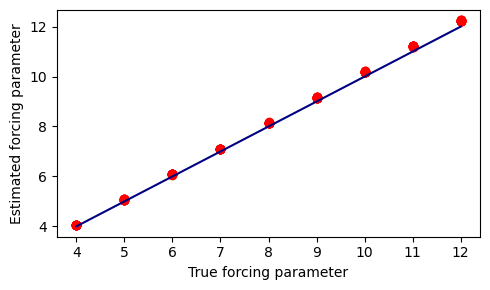

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(true_sorted, true_sorted, color="navy")
ax.scatter(true, estimated, color="red")
ax.set_ylabel("Estimated forcing parameter")
ax.set_xlabel("True forcing parameter")
plt.tight_layout()
plt.savefig("pt_evaluation.png", dpi=300)

In [7]:
df = pd.DataFrame({"true": true, "estim": estimated})

In [8]:
true_sorted = sorted(df["true"].unique())
estim_mean = df.groupby("true").mean()["estim"].values
estim_std = df.groupby("true").std()["estim"].values

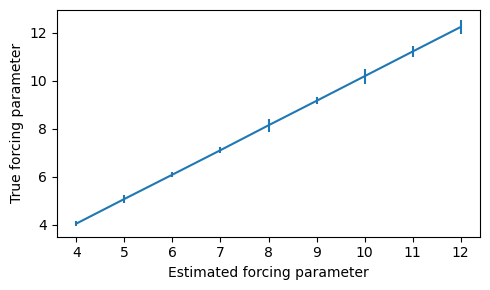

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# ax.plot(true_sorted, true_sorted, color="navy")
ax.errorbar(true_sorted, estim_mean, yerr=estim_std*20)

# ax.scatter(true, estimated, color="red")
ax.set_xlabel("Estimated forcing parameter")
ax.set_ylabel("True forcing parameter")
plt.tight_layout()
plt.savefig("pt_evaluation.png", dpi=300)

In [10]:
frame = {"true": true_sorted, "estim_mean": estim_mean, "estim_std": estim_std}
frame = pd.DataFrame(frame)
frame

,true,estim_mean,estim_std
0,4.0,4.048576,0.005776
1,5.0,5.073812,0.007834
2,6.0,6.086733,0.005790
3,7.0,7.104772,0.006676
4,8.0,8.139870,0.013011
5,9.0,9.158984,0.007220
6,10.0,10.184277,0.015261
7,11.0,11.211610,0.011057
8,12.0,12.232867,0.013786


# convergence

In [7]:
def read_from_tensorboard(path):
    the_path = os.path.join(path, "logs/lightning_logs/version_0")
    files = os.listdir(the_path)
    the_file = None
    for file in files:
        if "events" in file:
            the_file = os.path.join(the_path, file)
            break
    scalars = read_scalars_from_tensorboard(the_file)

    rmse = scalars["RMSEStateLeft/Training"]
    loss_data = scalars["DataLoss/Training"]
    loss_model = scalars["ModelLoss/Training"]
    loss = scalars["TotalLoss/Training"]
    param = scalars["Parameter/Training"]
    epoch = scalars["epoch"]
    return rmse, param, loss_data, loss_model, loss, epoch

In [8]:
state_rmse = {i: [] for i in range(4, 13)}
param_error = {i: [] for i in range(4, 13)}
loss_data = {i: [] for i in range(4, 13)}
loss_model = {i: [] for i in range(4, 13)}
loss_total = {i: [] for i in range(4, 13)}
epochs = {i: [] for i in range(4, 13)}
for path in hyda_experiments:
    config = load_hydra_config(path)
    training_data_path = config.datamodule.path_to_load_data
    with h5py.File(training_data_path) as file:
        true_forcing = file.attrs["forcing"]
    srmse, perror, lossd, lossm, losst, epoch = read_from_tensorboard(path)
    state_rmse[true_forcing].append(srmse)
    param_error[true_forcing].append(perror)
    loss_data[true_forcing].append(lossd)
    loss_model[true_forcing].append(lossm)
    loss_total[true_forcing].append(losst)
    epochs[true_forcing].append(epoch)

Text(0.5, 0, 'training step')

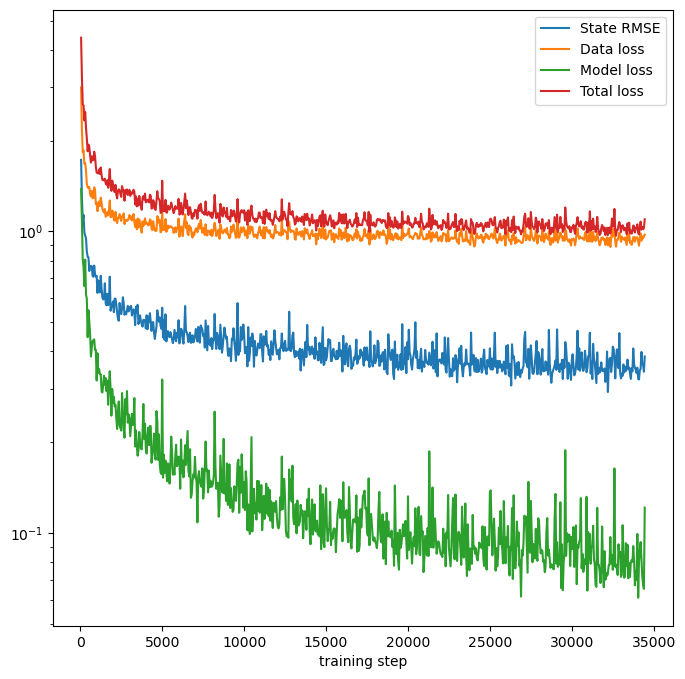

In [71]:
forcing = 10
id_exp = 8
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
srmse = state_rmse[forcing]
lossd = loss_data[forcing]
lossm = loss_model[forcing]
losst = loss_total[forcing]


ax.semilogy(srmse[id_exp].step.values, srmse[id_exp].value.values, label="State RMSE")
ax.semilogy(lossd[id_exp].step.values, lossd[id_exp].value.values, label="Data loss")
ax.semilogy(lossm[id_exp].step.values, lossm[id_exp].value.values, label="Model loss")
ax.semilogy(losst[id_exp].step.values, losst[id_exp].value.values, label="Total loss")



plt.legend()
ax.set_xlabel("training step")

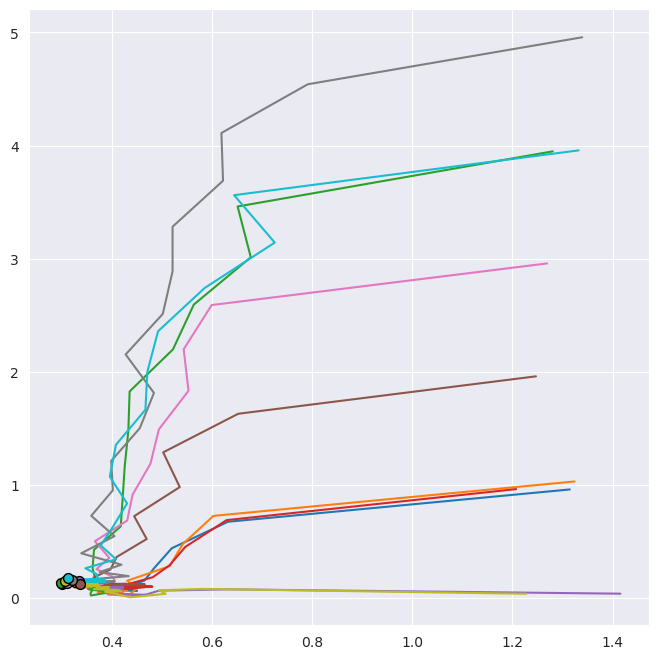

In [11]:
# all experiments for the same forcing
forcing = 8
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
srmse = state_rmse[forcing]
perror = param_error[forcing]
for sr, pe in zip(srmse, perror):
    x = sr.value.values[::10]
    y = np.abs(pe.value.values[::10] - forcing)
    ax.plot(x, y)
    ax.scatter(x[-1], y[-1], s=50, edgecolors='black', zorder=10)


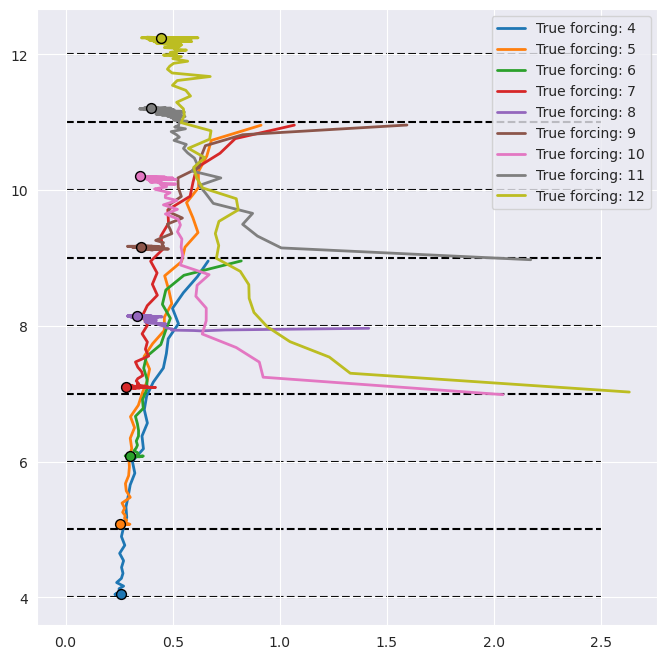

In [12]:
id_exp = 4
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for key in state_rmse:
    ax.hlines(key, 0, 2.5, color="black", linestyle="--", zorder=-1)
    
for key in state_rmse:
    srmse = state_rmse[key][id_exp].value.values[::5]
    perror = param_error[key][id_exp].value.values[::5]
    ax.plot(srmse, perror, label=f"True forcing: {key}", lw=2, zorder=1)
    ax.scatter(srmse[-1], perror[-1], s=50, edgecolors='black', zorder=2)
plt.legend()

In [13]:
from matplotlib.legend_handler import HandlerBase

class MarkerHandler(HandlerBase):
    def create_artists(self, legend, tup,xdescent, ydescent,
                       width, height, fontsize,trans):
        return [plt.Line2D([width/2], [height/2.],ls="",
                           marker=tup[1],color=tup[0], transform=trans)]


In [14]:
key = [key for key in state_rmse][0]
srmse = state_rmse[key][id_exp].value.values[::5]


/tmp/ipykernel_127504/1868564399.py:17: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axd["a"].scatter(srmse[-1], perror[-1], s=50, marker="x", edgecolors='black', zorder=2, facecolor=c)
/tmp/ipykernel_127504/1868564399.py:36: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axd["b"].scatter(x[-1], y[-1], s=50, marker="x", edgecolors='black', zorder=10, facecolor=c)


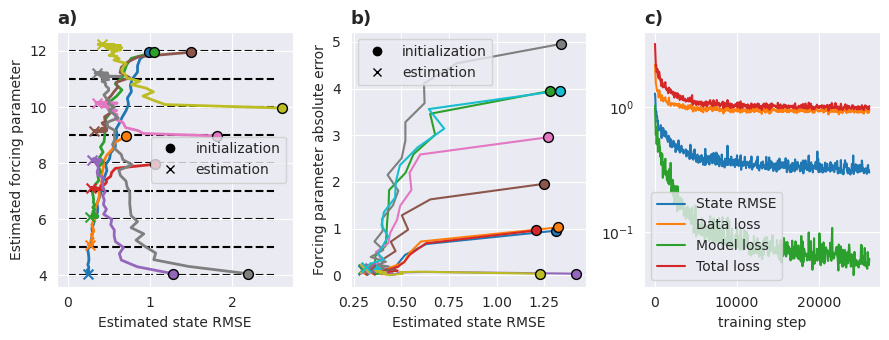

In [28]:
mosaic = """
abc
"""
id_exp = 2
forcing = 8
fig, axd = plt.subplot_mosaic(mosaic, figsize=(9, 3.5))


for key in state_rmse:
    axd["a"].hlines(key, 0, 2.5, color="black", linestyle="--", zorder=0)

for key in state_rmse:
    srmse = state_rmse[key][id_exp].value.values[::5]
    perror = param_error[key][id_exp].value.values[::5]
    h = axd["a"].plot(srmse, perror, label=f"True forcing: {key}", lw=2, zorder=1)
    c = h[-1].get_color()
    axd["a"].scatter(srmse[-1], perror[-1], s=50, marker="x", edgecolors='black', zorder=2, facecolor=c)    
    axd["a"].scatter(srmse[0], perror[0], s=50, marker="o", edgecolors='black', zorder=2, facecolor=c)

list_color = ["black", "black"]
list_mak = ["o", "x"]
list_lab = ["initialization", 'estimation']
axd["a"].legend(list(zip(list_color,list_mak)), list_lab,
                handler_map={tuple:MarkerHandler()})

axd["a"].set_xlabel("Estimated state RMSE")
axd["a"].set_ylabel("Estimated forcing parameter")

srmse = state_rmse[forcing]
perror = param_error[forcing]
for sr, pe in zip(srmse, perror):
    x = sr.value.values[::10]
    y = np.abs(pe.value.values[::10] - forcing)
    h = axd["b"].plot(x, y)
    c = h[-1].get_color()
    axd["b"].scatter(x[-1], y[-1], s=50, marker="x", edgecolors='black', zorder=10, facecolor=c)
    axd["b"].scatter(x[0], y[0], s=50, marker="o", edgecolors='black', zorder=10, facecolor=c)

axd["b"].set_xlabel("Estimated state RMSE")
axd["b"].set_ylabel("Forcing parameter absolute error")

axd["b"].legend(list(zip(list_color,list_mak)), list_lab,
                handler_map={tuple:MarkerHandler()})

srmse = state_rmse[forcing]
lossd = loss_data[forcing]
lossm = loss_model[forcing]
losst = loss_total[forcing]
axd["c"].semilogy(srmse[id_exp].step.values, srmse[id_exp].value.values, label="State RMSE")
axd["c"].semilogy(lossd[id_exp].step.values, lossd[id_exp].value.values, label="Data loss")
axd["c"].semilogy(lossm[id_exp].step.values, lossm[id_exp].value.values, label="Model loss")
axd["c"].semilogy(losst[id_exp].step.values, losst[id_exp].value.values, label="Total loss")

axd["c"].legend()
axd["c"].set_xlabel("training step")



for letter, ax in axd.items():
    ax.set_title(f"{letter})", loc="left", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.savefig("pt_evaluation.png", dpi=300)